In [1]:
# Importing required libraries
import torch
from sklearn.svm import SVC
import tensorflow as tf
from torch import nn
from icecream import ic
from torch.optim import Adam
from torchinfo import summary
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import os
from keras.callbacks import TensorBoard
import keras
from keras import layers
import numpy as np


# -------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(str(device))

N = 4  # number of images in whole picture
L_x = 5  # x and y pixel dims
L_y = 5
N_i = L_x * L_y
N_h = 256  # number of hidden units
N_o = 1  # number of output units


class IonImagesDataset(Dataset):
    def __init__(self, file_path):
        loaded_data_dict = torch.load(file_path)  # loading dataset into dataloader

        self.images = loaded_data_dict[
            "images"
        ]  # creating of 2 datasents of imgages and keys to them
        self.labels = loaded_data_dict["labels"]

    def __len__(self):
        return len(self.images)  # just return len function

    def __getitem__(self, idx):
        image_tensor = self.images[idx]  # Add a channel dimension
        label_tensor = self.labels[idx]  # Repeat the label for each ion position
        return image_tensor, label_tensor


file_path_pt = "binary\labels_and_images.pt"

# Loading in the data
dataset = IonImagesDataset(file_path_pt)
halfpi_dataset = IonImagesDataset(file_path_pt)

# Split the dataset into training and validation subsets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
print(
    f"Train size: {train_size}, Validation size: {val_size}"
)  # Print the sizes of subsets

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(
    f"Train dataset size: {len(train_dataset)}"
)  # Print the size of the train_dataset
print(
    f"Validation dataset size: {len(val_dataset)}"
)  # Print the size of the val_dataset

# Create DataLoaders for the training and validation datasets
batch_size = min(1000, len(train_dataset))  # or choose a smaller value
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=False
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, drop_last=False
)

halfpi_loader = DataLoader(
    halfpi_dataset, batch_size=batch_size, shuffle=True, drop_last=False
)


class IndexDependentDense(nn.Module):
    def __init__(self, N, N_i, N_o, activation=nn.ReLU()):
        super().__init__()

        self.N = N
        self.N_i = N_i
        self.N_o = N_o
        self.activation = activation

        # Initializing the parameters of the network
        self.register_parameter(
            "W", nn.Parameter(torch.empty(self.N, self.N_i, self.N_o))
        )
        self.register_parameter("b", nn.Parameter(torch.empty(self.N, self.N_o)))

        self._reset_parameters()

        pass

    def _reset_parameters(self):  # Initiating the network with values
        nn.init.xavier_uniform_(self.W)
        nn.init.zeros_(self.b)

    def forward(self, x):  # Defining the forward pass through the network using torch
        y = torch.einsum("nij,...ni->...nj", self.W, x) + self.b
        if self.activation is not None:
            return self.activation(y)
        else:
            return y

    pass


# ---------------------------------------------------------------------------------------------


class Encoder(
    nn.Module
):  # Creating an encoder using the above IndexDependentDense architecture
    def __init__(self, N, N_i, N_o):
        super().__init__()

        self.N = N
        self.N_i = N_i
        self.N_o = N_o

        self.dense = IndexDependentDense(N, N_i, N_o, activation=nn.ReLU())
        pass

    def forward(self, x):
        y = self.dense(x)
        return y

    pass


# ---------------------------------------------------------------------------------------------


class Classifier(
    nn.Module
):  # Creating a classifier using the above IndexDependentDense architecture
    def __init__(self, N, N_i, N_o):
        super().__init__()

        self.N = N
        self.N_i = N_i
        self.N_o = N_o
        self.dense = IndexDependentDense(N, N_i, N_o, activation=None)
        pass

    def forward(self, x):
        y = self.dense(x)
        y = torch.sigmoid(y)  # Apply sigmoid activation here
        return y

    pass


# ---------------------------------------------------------------------------------------------


class SharedEncoder(
    nn.Module
):  # Creating a shared encoder using default linear architecture
    def __init__(self, N, N_i, N_o):
        super().__init__()

        self.N = N
        self.N_i = N_i
        self.N_o = N_o

        self.dense = nn.Linear(N_i, N_o)
        pass

    def forward(self, x):
        y = self.dense(x)
        return y

    pass


# ---------------------------------------------------------------------------------------------


class MultiIonReadout(nn.Module):
    def __init__(self, encoder, shared_encoder, classifier):
        super().__init__()

        self.encoder = encoder
        self.shared_encoder = shared_encoder
        self.classifier = classifier

    def forward(self, x):
        y = x.reshape(*x.shape[:-2], -1).to(
            torch.float32
        )  # Reshaping the data for the forwards pass
        y1 = self.encoder(y)
        y2 = self.shared_encoder(y)
        y_concat = torch.cat(
            [y1, y2], dim=-1
        )  # Combining the data for each y node for returning the classification
        y = self.classifier(y_concat)
        return y

    def bceloss(self, X, y):  # Setting binary cross entropy as the loss function
        return F.binary_cross_entropy(self(X), y)

    @staticmethod
    def _accuracy(y_pred, y_true):  # Defining the accuracy prediction metric
        mod_y_pred = (y_pred > 0.5).to(torch.float32)
        accuracy = (y_true == mod_y_pred).to(dtype=torch.float32).mean()
        return accuracy * 100

    def accuracy(self, x, y):
        return self._accuracy(self(x), y)


# ---------------------------------------------------------------------------------------------

ModuleNotFoundError: No module named 'torchinfo'

In [ ]:
device = torch.device("cpu")
# model
encoder = Encoder(N, N_i, N_h)
shared_encoder = SharedEncoder(N, N_i, N_h)
classifier = Classifier(N, N_h * 2, N_o)
model = MultiIonReadout(encoder, shared_encoder, classifier)

# Setting the model parameters and saving to variables
model = model.to(device)
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params2 = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)
print(pytorch_total_params2)

# Setting the hyperparameters
N_epochs = 100
lr = 1e-3
optimizer = Adam(model.parameters(), lr=lr)
schedule_params = {"factor": 1}
schedule = lr_scheduler.ConstantLR(optimizer, **schedule_params)
log_every = 1

# Training loop
for epoch in range(N_epochs):

    total_train_loss = 0
    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        loss = model.bceloss(inputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluation loop
    with torch.no_grad():
        total_loss = 0
        total_accuracy = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            loss = model.bceloss(inputs, labels)
            accuracy = model.accuracy(inputs, labels)
            total_loss += loss.item()
            total_accuracy += accuracy.item()

        avg_loss = total_loss / len(val_loader)
        avg_accuracy = total_accuracy / len(val_loader)

    print(
        "\r Epoch {}/{}, Training Loss = {}, Val Loss = {}, Val Acc = {}".format(
            epoch + 1, N_epochs, loss.item(), avg_loss, avg_accuracy
        ),
        end="",
    )

# torch.save(model.state_dict(), "golden_WandB_n.pth")

35332
35332
 Epoch 100/100, Training Loss = 0.23107455670833588, Val Loss = 0.23882950097322464, Val Acc = 92.07500076293945

In [ ]:
device = torch.device("cpu")
# model
encoder = Encoder(N, N_i, N_h)
shared_encoder = SharedEncoder(N, N_i, N_h)
classifier = Classifier(N, N_h * 2, N_o)
model = MultiIonReadout(encoder, shared_encoder, classifier)


# Setting the model parameters and saving to variables
model = model.to(device)
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params2 = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)
print(pytorch_total_params2)

# Setting the hyperparameters
N_epochs = 100
lr = 1e-3
optimizer = Adam(model.parameters(), lr=lr)
schedule_params = {"factor": 1}
schedule = lr_scheduler.ConstantLR(optimizer, **schedule_params)
log_every = 1

# Training loop
for epoch in range(N_epochs):

    total_train_loss = 0
    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        loss = model.bceloss(inputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluation loop
    with torch.no_grad():
        total_loss = 0
        total_accuracy = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            loss = model.bceloss(inputs, labels)
            accuracy = model.accuracy(inputs, labels)
            total_loss += loss.item()
            total_accuracy += accuracy.item()

        avg_loss = total_loss / len(val_loader)
        avg_accuracy = total_accuracy / len(val_loader)

    print(
        "\r Epoch {}/{}, Training Loss = {}, Val Loss = {}, Val Acc = {}".format(
            epoch + 1, N_epochs, loss.item(), avg_loss, avg_accuracy
        ),
        end="",
    )

# torch.save(model.state_dict(), "golden_WandB_n.pth")

35332
35332
 Epoch 100/100, Training Loss = 0.23692470788955688, Val Loss = 0.23414544761180878, Val Acc = 92.07500076293945

### Autoencoder

In [ ]:
# This is the size of our encoded representations
encoding_dim = 16  # Size of minimal layer, we set to 4 here to try to mirror the four true states that exist in the process
image_size = 100  # Linear size of images

# Types convolution, deep, basic
model_type = "deep"

if model_type == "basic":
    # This is our input image
    input_img = keras.Input(shape=(image_size,))
    # "encoded" is the encoded representation of the input
    encoded = layers.Dense(encoding_dim, activation="relu")(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded = layers.Dense(image_size)(encoded)

elif model_type == "deep":
    input_img = keras.Input(shape=(image_size,))
    encoded = layers.Dense(int(image_size / 2), activation="relu")(
        input_img
    )  # Here we repeat the above process for a model with three layers
    encoded = layers.Dense(int(image_size / 4), activation="relu")(encoded)
    encoded = layers.Dense(encoding_dim, activation="relu")(encoded)

    decoded = layers.Dense(int(image_size / 4), activation="relu")(encoded)
    decoded = layers.Dense(int(image_size / 2), activation="relu")(decoded)
    decoded = layers.Dense(image_size)(decoded)

elif model_type == "convolution":
    input_img = keras.Input(shape=(4, 25, 1))

    x = layers.Conv2D(16, (1, 4), activation="relu", padding="same")(
        input_img
    )  # Applying simple convolutional and pooling layers to simplify the data to one dimensional form
    x = layers.MaxPooling2D((2, 2), padding="same")(x)
    x = layers.Conv2D(8, (1, 4), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)
    x = layers.Conv2D(8, (1, 4), activation="relu", padding="same")(x)
    encoded = layers.MaxPooling2D((2, 2), padding="same")(x)

    x = layers.Conv2D(8, (1, 4), activation="relu", padding="same")(
        encoded
    )  # Expanding the data back into the origional images
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(8, (1, 4), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(16, (1, 4), activation="relu")(x)
    x = layers.UpSampling2D((1, 2))(
        x
    )  # Altering the final reconstruction sampling to account for uneven sizes of 25 and 4
    decoded = layers.Conv2D(1, (1, 2), padding="valid")(x)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

In [ ]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

In [ ]:
# This model will recreate an image through compression and expansion of the data
autoencoder.compile(optimizer="adam", loss="mean_squared_error")

In [ ]:
# Converting our data from tensors to numpy arrays and seperating out labels for the unsupervised step
x_train = next(iter(train_loader))[0].numpy()
y_train = next(iter(train_loader))[1].numpy()

# Creating transformed dataset for the testing data
x_test = next(iter(val_loader))[0].numpy()
y_test = next(iter(val_loader))[1].numpy()

# Creating transformed dataset for the halfpi data
x_true = next(iter(halfpi_loader))[0].numpy()
y_true = next(iter(halfpi_loader))[1].numpy()

In [ ]:
# Converting the data to black and white pixels
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_true = x_true.astype("float32") / 255.0

# Reshaping the input data to fit the form of each of our models above
if model_type == "convolution":
    x_train = np.reshape(x_train, (len(x_train), 4, 25, 1))
    x_test = np.reshape(x_test, (len(x_test), 4, 25, 1))
    x_true = np.reshape(x_true, (len(x_true), 4, 25, 1))
else:
    x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
    x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
    x_true = x_true.reshape((len(x_true), np.prod(x_true.shape[1:])))

# Returning model shapes
print(x_train.shape)
print(x_test.shape)
print(x_true.shape)

(1000, 100)
(1000, 100)
(1000, 100)


In [ ]:
history = autoencoder.fit(
    x_test,
    x_test,
    epochs=300,
    batch_size=16,
    shuffle=True,
    validation_data=(x_train, x_train),
    callbacks=[TensorBoard(log_dir="/tmp/autoencoder")],
)

Epoch 1/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 3.1715e-04 - val_loss: 2.9550e-04
Epoch 2/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9670e-04 - val_loss: 2.8299e-04
Epoch 3/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7049e-04 - val_loss: 2.5914e-04
Epoch 4/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5705e-04 - val_loss: 2.3934e-04
Epoch 5/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2876e-04 - val_loss: 2.2326e-04
Epoch 6/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2192e-04 - val_loss: 2.1532e-04
Epoch 7/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1304e-04 - val_loss: 2.0861e-04
Epoch 8/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0510e-04 - val_loss: 1.9794e-04
Epoch 9/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9485e-04 - val_loss: 1.9448e-04
Epoch 10/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9382e-04 - val_loss: 1.9141e-04
Epoch 11/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8859e-0

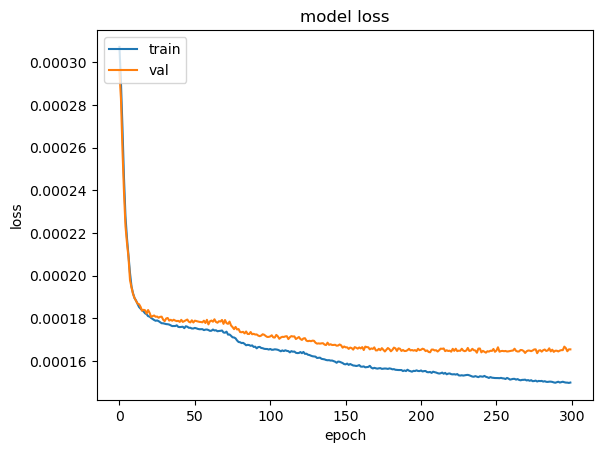

In [ ]:
# Plotting the loss of the model over time
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [ ]:
# Encode and decode some digits for each of our sets
encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)
decoded_train = autoencoder.predict(x_train)
decoded_true = autoencoder.predict(x_true)
encoded_true = encoder.predict(x_true)
encoded_test = encoded_imgs
encoded_train = encoder.predict(x_train)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [ ]:
# Setting needed environ variables to allow keras and matplotlib to interplay
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

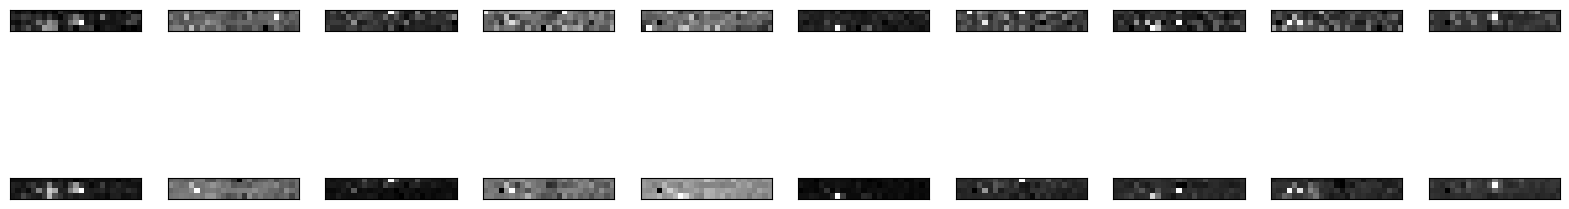

In [ ]:
# Use Matplotlib (don't ask)
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(4, 25))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(4, 25))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# Subtracting the real images from the decoded images and dividing by number of pixels to get accuracy of autoencoding
reconstruction_acc = 1 - np.sum(abs(x_test - decoded_imgs)) / 100000
print("The reconstruction is", round(reconstruction_acc * 100, 3), "percent accurate")

The reconstruction is 99.146 percent accurate


In [ ]:
print(encoded_train.shape, y_train.shape)

(1000, 16) (1000, 4, 1)


In [ ]:
# Reshaping arrays to remove size one third dimension
y_true = y_true[:, :, 0]
y_train = y_train[:, :, 0]
y_test = y_test[:, :, 0]

In [ ]:
# Converting the central encoding layer into basic true false data

# If the model is convolutional need to simplify the 4 by 8 data into four bits
if model_type == "convolution":
    encoded_test = np.sum(encoded_test, axis=-1).reshape(1000, 4)
    encoded_train = np.sum(encoded_train, axis=-1).reshape(1000, 4)
    encoded_true = np.sum(encoded_true, axis=-1).reshape(1000, 4)

# As a default test check if the data is above average and map to 0 and 1 bits
av = np.average(encoded_test)
preds_raw = encoded_test > av

# Calculate the accuracy of the model in bit prediction if using a 4 size central dimension
if encoding_dim == 4:
    np.sum(abs(preds_raw - y_test)) / 4000

In [ ]:
# Clearly the four bits can not be interpereted directly, attempt simple classification to see if a basic remapping will solve the issue
forest = SVC(gamma="auto")
multi_target_forest = MultiOutputClassifier(forest, n_jobs=4).fit(
    encoded_train, y_train
)
predictions_forest = multi_target_forest.predict(encoded_train)
np.sum(abs(predictions_forest - y_test)) / 4000

0.49725

Once more the bits do not seem to be simply seperable from the encoder data as such we move forwards with prediction using a nn from our data

### Predictions Using Encoder Data

In [ ]:
# -------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(str(device))

N = 4  # number of images in whole picture
L_x = 5  # x and y pixel dims
L_y = 5
N_i = L_x * L_y
N_h = 256  # number of hidden units
N_o = 1  # number of output units


class IonImagesDataset(Dataset):
    def __init__(self, file_path):
        loaded_data_dict = torch.load(file_path)  # loading dataset into dataloader

        self.images = loaded_data_dict[
            "images"
        ]  # creating of 2 datasents of imgages and keys to them
        self.labels = loaded_data_dict["labels"]

    def __len__(self):
        return len(self.images)  # just return len function

    def __getitem__(self, idx):
        image_tensor = self.images[idx]  # Add a channel dimension
        label_tensor = self.labels[idx]  # Repeat the label for each ion position
        return image_tensor, label_tensor


file_path_pt = "binary\labels_and_images.pt"

# Loading in the data
dataset = IonImagesDataset(file_path_pt)
halfpi_dataset = IonImagesDataset(file_path_pt)

# Split the dataset into training and validation subsets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
print(
    f"Train size: {train_size}, Validation size: {val_size}"
)  # Print the sizes of subsets

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(
    f"Train dataset size: {len(train_dataset)}"
)  # Print the size of the train_dataset
print(
    f"Validation dataset size: {len(val_dataset)}"
)  # Print the size of the val_dataset

# Create DataLoaders for the training and validation datasets
batch_size = min(1000, len(train_dataset))  # or choose a smaller value
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=False
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, drop_last=False
)

halfpi_loader = DataLoader(
    halfpi_dataset, batch_size=batch_size, shuffle=True, drop_last=False
)


class IndexDependentDense(nn.Module):
    def __init__(self, N, N_i, N_o, activation=nn.ReLU()):
        super().__init__()

        self.N = N
        self.N_i = N_i
        self.N_o = N_o
        self.activation = activation

        # Initializing the parameters of the network
        self.register_parameter(
            "W", nn.Parameter(torch.empty(self.N, self.N_i, self.N_o))
        )
        self.register_parameter("b", nn.Parameter(torch.empty(self.N, self.N_o)))

        self._reset_parameters()

        pass

    def _reset_parameters(self):  # Initiating the network with values
        nn.init.xavier_uniform_(self.W)
        nn.init.zeros_(self.b)

    def forward(self, x):  # Defining the forward pass through the network using torch
        y = torch.einsum("nij,...ni->...nj", self.W, x) + self.b
        if self.activation is not None:
            return self.activation(y)
        else:
            return y

    pass


# ---------------------------------------------------------------------------------------------


class Encoder(
    nn.Module
):  # Creating an encoder using the above IndexDependentDense architecture
    def __init__(self, N, N_i, N_o):
        super().__init__()

        self.N = N
        self.N_i = N_i
        self.N_o = N_o

        self.dense = IndexDependentDense(N, N_i, N_o, activation=nn.ReLU())
        pass

    def forward(self, x):
        y = self.dense(x)
        return y

    pass


# ---------------------------------------------------------------------------------------------


class Classifier(
    nn.Module
):  # Creating a classifier using the above IndexDependentDense architecture
    def __init__(self, N, N_i, N_o):
        super().__init__()

        self.N = N
        self.N_i = N_i
        self.N_o = N_o
        self.dense = IndexDependentDense(N, N_i, N_o, activation=None)
        pass

    def forward(self, x):
        y = self.dense(x)
        y = torch.sigmoid(y)  # Apply sigmoid activation here
        return y

    pass


# ---------------------------------------------------------------------------------------------


class SharedEncoder(
    nn.Module
):  # Creating a shared encoder using default linear architecture
    def __init__(self, N, N_i, N_o):
        super().__init__()

        self.N = N
        self.N_i = N_i
        self.N_o = N_o

        self.dense = nn.Linear(N_i, N_o)
        pass

    def forward(self, x):
        y = self.dense(x)
        return y

    pass


# ---------------------------------------------------------------------------------------------


class MultiIonReadout(nn.Module):
    def __init__(self, encoder, shared_encoder, classifier):
        super().__init__()

        self.encoder = encoder
        self.shared_encoder = shared_encoder
        self.classifier = classifier

    def forward(self, x):
        y = x.reshape(*x.shape[:-2], -1).to(
            torch.float32
        )  # Reshaping the data for the forwards pass
        y1 = self.encoder(y)
        y2 = self.shared_encoder(y)
        y_concat = torch.cat(
            [y1, y2], dim=-1
        )  # Combining the data for each y node for returning the classification
        y = self.classifier(y_concat)
        return y

    def bceloss(self, X, y):  # Setting binary cross entropy as the loss function
        return F.binary_cross_entropy(self(X), y)

    @staticmethod
    def _accuracy(y_pred, y_true):  # Defining the accuracy prediction metric
        mod_y_pred = (y_pred > 0.5).to(torch.float32)
        accuracy = (y_true == mod_y_pred).to(dtype=torch.float32).mean()
        return accuracy * 100

    def accuracy(self, x, y):
        return self._accuracy(self(x), y)


# ---------------------------------------------------------------------------------------------

cpu
Train size: 8000, Validation size: 2000
Train dataset size: 8000
Validation dataset size: 2000


In [ ]:
device = torch.device("cpu")
# model
encoder = Encoder(N, N_i, N_h)
shared_encoder = SharedEncoder(N, N_i, N_h)
classifier = Classifier(N, N_h * 2, N_o)
model = MultiIonReadout(encoder, shared_encoder, classifier)

# Setting the model parameters and saving to variables
model = model.to(device)
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params2 = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)
print(pytorch_total_params2)

# Setting the hyperparameters
N_epochs = 100
lr = 1e-3
optimizer = Adam(model.parameters(), lr=lr)
schedule_params = {"factor": 1}
schedule = lr_scheduler.ConstantLR(optimizer, **schedule_params)
log_every = 1

# Training loop
for epoch in range(N_epochs):

    total_train_loss = 0
    for inputs, labels in train_loader:
        if model_type == "convolution":
            inputs = autoencoder.predict(inputs.reshape(-1, 4, 25, 1)).reshape(
                -1, 4, 5, 5
            )  # Two additional lines from before to ensure shape is correct for inputting
        else:
            inputs = autoencoder.predict(inputs.reshape(-1, 100)).reshape(
                -1, 4, 5, 5
            )  # Two additional lines from before to ensure shape is correct for inputting
        inputs = torch.tensor(inputs)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        loss = model.bceloss(inputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluation loop
    with torch.no_grad():
        total_loss = 0
        total_accuracy = 0
        for inputs, labels in val_loader:
            if model_type == "convolution":
                inputs = autoencoder.predict(inputs.reshape(-1, 4, 25, 1)).reshape(
                    -1, 4, 5, 5
                )  # Two additional lines from before to ensure shape is correct for inputting
            else:
                inputs = autoencoder.predict(inputs.reshape(-1, 100)).reshape(
                    -1, 4, 5, 5
                )  # Two additional lines from before to ensure shape is correct for inputting
            inputs = torch.tensor(inputs)
            inputs, labels = inputs.to(device), labels.to(device)

            loss = model.bceloss(inputs, labels)
            accuracy = model.accuracy(inputs, labels)
            total_loss += loss.item()
            total_accuracy += accuracy.item()

        avg_loss = total_loss / len(val_loader)
        avg_accuracy = total_accuracy / len(val_loader)

    print(
        "\r Epoch {}/{}, Training Loss = {}, Val Loss = {}, Val Acc = {}".format(
            epoch + 1, N_epochs, loss.item(), avg_loss, avg_accuracy
        ),
        end="",
    )

# torch.save(model.state_dict(), "golden_WandB_n.pth")

35332
35332
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 514984, Val Acc = 65.87
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 67047, Val Acc = 76.05000305175
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━

In [ ]:
device = torch.device("cpu")
# model
encoder = Encoder(N, N_i, N_h)
shared_encoder = SharedEncoder(N, N_i, N_h)
classifier = Classifier(N, N_h * 2, N_o)
model = MultiIonReadout(encoder, shared_encoder, classifier)


# Setting the model parameters and saving to variables
model = model.to(device)
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params2 = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)
print(pytorch_total_params2)

# Setting the hyperparameters
N_epochs = 100
lr = 1e-3
optimizer = Adam(model.parameters(), lr=lr)
schedule_params = {"factor": 1}
schedule = lr_scheduler.ConstantLR(optimizer, **schedule_params)
log_every = 1

# Training loop
for epoch in range(N_epochs):

    total_train_loss = 0
    for (
        inputs,
        labels,
    ) in (
        train_loader
    ):  # Two additional lines from before to ensure shape is correct for inputting
        if model_type == "convolution":
            inputs = autoencoder.predict(inputs.reshape(-1, 4, 25, 1)).reshape(
                -1, 4, 5, 5
            )  # Two additional lines from before to ensure shape is correct for inputting
        else:
            inputs = autoencoder.predict(inputs.reshape(-1, 100)).reshape(
                -1, 4, 5, 5
            )  # Two additional lines from before to ensure shape is correct for inputting
        inputs = torch.tensor(inputs)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        loss = model.bceloss(inputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluation loop
    with torch.no_grad():
        total_loss = 0
        total_accuracy = 0
        for (
            inputs,
            labels,
        ) in (
            val_loader
        ):  # Two additional lines from before to ensure shape is correct for inputting
            if model_type == "convolution":
                inputs = autoencoder.predict(inputs.reshape(-1, 4, 25, 1)).reshape(
                    -1, 4, 5, 5
                )  # Two additional lines from before to ensure shape is correct for inputting
            else:
                inputs = autoencoder.predict(inputs.reshape(-1, 100)).reshape(
                    -1, 4, 5, 5
                )  # Two additional lines from before to ensure shape is correct for inputting
            inputs = torch.tensor(inputs)
            inputs, labels = inputs.to(device), labels.to(device)

            loss = model.bceloss(inputs, labels)
            accuracy = model.accuracy(inputs, labels)
            total_loss += loss.item()
            total_accuracy += accuracy.item()

        avg_loss = total_loss / len(val_loader)
        avg_accuracy = total_accuracy / len(val_loader)

    print(
        "\r Epoch {}/{}, Training Loss = {}, Val Loss = {}, Val Acc = {}".format(
            epoch + 1, N_epochs, loss.item(), avg_loss, avg_accuracy
        ),
        end="",
    )

# torch.save(model.state_dict(), "golden_WandB_n.pth")

35332
35332
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 216858, Val Acc = 70.7250022888183
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 83618927, Val Acc = 78.0124969482421
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

### Manual AE

This approach proved less effective than the previous methods, however it is being kept here for documentation of the process

In [ ]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 100 ==> 4
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(100, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 9),
            torch.nn.ReLU(),
            torch.nn.Linear(9, 4),
        )

        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # 4 ==> 100
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(4, 9),
            torch.nn.ReLU(),
            torch.nn.Linear(9, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 100),
            torch.nn.ReLU(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
# Model Initialization
auto_model = AE()

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(auto_model.parameters(), lr=1e-1, weight_decay=1e-8)

In [ ]:
# Transforms images to a PyTorch Tensor
tensor_transform = transforms.ToTensor()

# DataLoader is used to load the dataset
# for training
loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=256, shuffle=True
)

In [ ]:
epochs = 100
outputs = []
losses = []
for epoch in range(epochs):
    for image, _ in loader:

        # Reshaping the image to (-1, 784)
        image = image.reshape(-1, 100)

        # Output of Autoencoder
        reconstructed = auto_model(image)

        # Calculating the loss function
        loss = loss_function(reconstructed, image)

        # The gradients are set to zero,
        # the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Storing the losses in a list for plotting
        losses.append(loss)
    outputs.append((epochs, image, reconstructed))

In [ ]:
# Formatting the losses
losses_np = torch.stack(losses).detach().numpy()

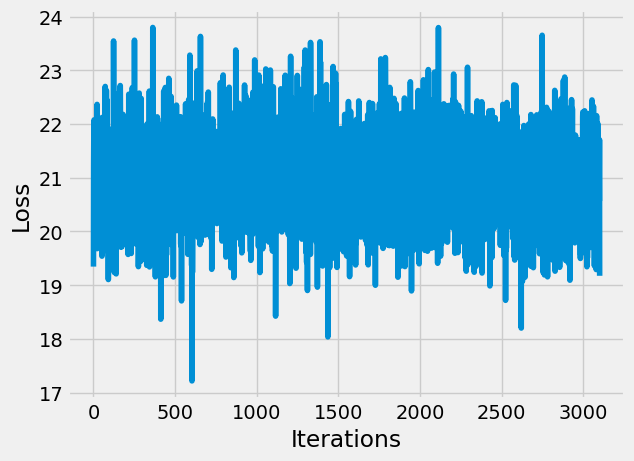

In [ ]:
# Defining the Plot Style
plt.style.use("fivethirtyeight")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.plot(losses_np[100:])

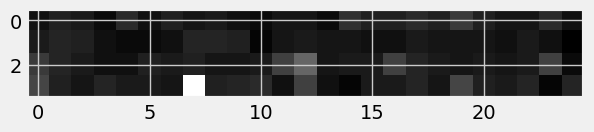

In [ ]:
for i, item in enumerate(image):
    # Reshape the array for plotting
    item = item.reshape(-1, 4, 25)
    plt.imshow(item.detach().numpy()[0])

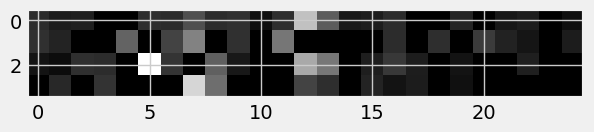

In [ ]:
for i, item in enumerate(reconstructed):
    # Reshape the array for plotting
    item = item.reshape(-1, 4, 25)
    plt.imshow(item.detach().numpy()[0])

In [ ]:
# Creating a dataset based off of the previous information
simplified_data = []
truth = []
tuple_simplified = []
for image, label in dataset:
    image = image.reshape(-1, 100)
    encoded_data = auto_model.encoder(image)
    simplified_data.append(encoded_data.detach().numpy())
    truth.append(label)
    tuple_simplified.append((encoded_data, label))

In [ ]:
# Formatting the data for future usage
Y = torch.stack(truth).detach().numpy()
Y = Y[:, :, 0]
X = np.vstack(simplified_data)

In [ ]:
# Data splitting
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

In [ ]:
# Setting up a basic prediction model
SVC_model = SVC(gamma="auto")
multi_target_SVC = MultiOutputClassifier(SVC_model, n_jobs=4).fit(X_train, y_train)
predictions = multi_target_SVC.predict(X_test)

In [ ]:
# Comparing the raw predictions to the true data
raw_preds = np.ceil(np.clip(X, 0, 1))
print("Accuracy of Raw Predictions are", 1 - np.sum(np.abs(raw_preds - Y)) / 40000)

Accuracy of Raw Predictions are 0.5


In [ ]:
# Comparing forest prediction strength
print(
    "Accuracy of SVC Predictions are", 1 - np.sum(np.abs(y_test - predictions)) / 8000
)

Accuracy of SVC Predictions are 0.49612500000000004
